## Part 3: Modeling and Model Selection

I am trying to compare the <mark>*Random Forest, Logistic Regression, Support Vector Machine, and Multinomial Naive Bayes*</mark> models and will select the one with best accuracy score.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.svm import SVC


In [2]:
# import cleaned comments data from csv
df = pd.read_csv('comments_clean.csv')
df.head()

,body,length,word_count,target
0,typically hosting centralized service and mere...,186,30,1
1,yup feast for,25,6,1
2,4000 you kidding right the floor bored ape lik...,68,13,1
3,prognosis negative someone dropped fucking jun...,72,11,1
4,nano but for monkey,22,4,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   body        3232 non-null   object
 1   length      3232 non-null   int64 
 2   word_count  3232 non-null   int64 
 3   target      3232 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 101.1+ KB


### set up X and y, train/test split

In [4]:
X = df['body']
y = df['target']

y.value_counts(normalize=True) # baseline accuracy



1    0.541151
0    0.458849
Name: target, dtype: float64

In [5]:
# train/test split
# stratify y just in case, even though the classes are balanced
# test_size : default = 0.25
# shuffle: default = True

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y, #to keep the same balance of y in the test and train data
                                                    random_state=42)

In [6]:
X_train.shape

(2424,)

In [7]:
X_test.shape

(808,)

In [8]:
y_train.shape

(2424,)

In [9]:
y_test.shape

(808,)

## Model x1-1: CountVectorizer & Logistic Regression

In [10]:
# set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)

pipe1_1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [11]:
pipe1_1.fit(X_train, y_train)
pipe1_1.score(X_train, y_train), pipe1_1.score(X_test, y_test)

(0.9575082508250825, 0.7388613861386139)

In [12]:
pipe1_cv = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe1_cv.fit(X_train, y_train)
pipe1_cv.score(X_train, y_train), pipe1_cv.score(X_test, y_test)

# Search over the following values of hyperparameters:
pipe_x1_params = {
    'cvec__max_features' : [5_000, 10_000, 15_000],# Maximum number of features fit: 5000, 10,000, 15,000
    'cvec__min_df' : [2,3], # Minimum number of documents needed to include token: 2, 3
    'cvec__max_df': [0.9, 0.95], # Maximum number of documents needed to include token: 90%, 95%
    'cvec__ngram_range' : [(1,1), (1,2)], # Check (individual tokens) and also check (individual tokens and 2-grams)
    'cvec__stop_words':[None, 'english']
}

# Instantiate GridSearchCV
pipe1_gs = GridSearchCV(pipe1_cv,
                    pipe_x1_params,
                    cv =5,
                    verbose = 1,
                    n_jobs = -1)

# Fit GridSearch to training data
pipe1_gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 10000, 15000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

In [13]:
print(pipe1_gs.best_params_)
print(f'Cross Val: {pipe1_gs.best_score_}')
print(f'Training Accuracy: {pipe1_gs.score(X_train, y_train)}')
print(f'Testing Accuracy: {pipe1_gs.score(X_test, y_test)}')

pipe1_gs_pred = pipe1_gs.predict(X_test)

print(f'Precision: {precision_score(y_test, pipe1_gs_pred)}')
print(f'F1 score: {f1_score(y_test,pipe1_gs_pred)}')
print(f'Recall: {recall_score(y_test, pipe1_gs_pred)}')

{'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
Cross Val: 0.6976152338757775
Training Accuracy: 0.9302805280528053
Testing Accuracy: 0.7339108910891089
Precision: 0.73125
F1 score: 0.7655398037077425
Recall: 0.8032036613272311


## Model x1-2: TF - IDF Vectorizer & Logistic Regression

In [14]:
pipe1_tfdf = Pipeline([
                ('tf', TfidfVectorizer()),
                ('lr', LogisticRegression())
])

pipe1_tfdf.fit(X_train, y_train)
pipe1_tfdf.score(X_train, y_train), pipe1_tfdf.score(X_test, y_test)


pipe_x12_params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__min_df': [2, 3],
                'tf__max_df': [0.75,0.9],
                'tf__ngram_range':[(1, 1), (1, 2)],
                'tf__stop_words':['english',None]
                
}

pipe12_gs = GridSearchCV(pipe1_tfdf,
                    pipe_x12_params,
                    cv =5,
                    verbose = 1,
                    n_jobs = -1)
pipe12_gs.fit(X_train, y_train)

print(pipe12_gs.best_params_)
print(f'Cross Val: {pipe12_gs.best_score_}')
print(f'Training Accuracy: {pipe12_gs.score(X_train, y_train)}')
print(f'Testing Accuracy: {pipe12_gs.score(X_test, y_test)}')

pipe12_gs_pred = pipe12_gs.predict(X_test)

print(f'Precision: {precision_score(y_test, pipe12_gs_pred)}')
print(f'F1 score: {f1_score(y_test,pipe12_gs_pred)}')
print(f'Recall: {recall_score(y_test, pipe12_gs_pred)}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'tf__max_df': 0.75, 'tf__max_features': 5000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Cross Val: 0.703801652892562
Training Accuracy: 0.8993399339933993
Testing Accuracy: 0.75
Precision: 0.7373737373737373
F1 score: 0.7832618025751074
Recall: 0.8352402745995423


## Model x2-1: CountVectorizer & Random Forest Classifier

In [15]:
pipe2_cvc = Pipeline([
                ('cvec', CountVectorizer()),
                ('rf', RandomForestClassifier())
])
pipe2_cvc.fit(X_train, y_train)
pipe2_cvc.score(X_train, y_train), pipe2_cvc.score(X_test, y_test)


pipe_x21_params = {
                'cvec__max_features' : [5000,10_000,15_000],
                'cvec__min_df': [2, 3],
                'cvec__max_df': [0.75,0.9],
                'cvec__ngram_range':[(1, 1), (1, 2)],
                'cvec__stop_words':['english',None]
                
}

pipe21_gs = GridSearchCV(pipe2_cvc,
                    pipe_x21_params,
                    cv =5,
                    verbose = 1,
                    n_jobs = -1)
pipe21_gs.fit(X_train, y_train)

print(pipe21_gs.best_params_)
print(f'Cross Val: {pipe21_gs.best_score_}')
print(f'Training Accuracy: {pipe21_gs.score(X_train, y_train)}')
print(f'Testing Accuracy: {pipe21_gs.score(X_test, y_test)}')

pipe21_gs_pred = pipe21_gs.predict(X_test)

print(f'Precision: {precision_score(y_test, pipe21_gs_pred)}')
print(f'F1 score: {f1_score(y_test,pipe21_gs_pred)}')
print(f'Recall: {recall_score(y_test, pipe21_gs_pred)}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'cvec__max_df': 0.9, 'cvec__max_features': 15000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
Cross Val: 0.6773826361080344
Training Accuracy: 0.9764851485148515
Testing Accuracy: 0.7165841584158416
Precision: 0.7241379310344828
F1 score: 0.7458379578246392
Recall: 0.7688787185354691


In [16]:
# y_pred = gs3.predict(X_test)
# cm_def = np.array([['True Negative', 'False Positive'],
#                 ['False Negative', 'True Positive']])
# cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
# cm = confusion_matrix(y_test, y_pred)
# cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
# display(cm_def)
# display(cm_df)

## Model x2-2: TFIDF and Random Forest Classifer

In [17]:
pipe2_tfrf = Pipeline([
                ('tf', TfidfVectorizer()),
                ('rf', RandomForestClassifier())
])

pipe2_tfrf.fit(X_train, y_train)
pipe2_tfrf.score(X_train, y_train), pipe2_tfrf.score(X_test, y_test)


pipe_x22_params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__min_df': [2, 3],
                'tf__max_df': [0.75,0.9],
                'tf__ngram_range':[(1, 1), (1, 2)],
                'tf__stop_words':['english',None]
                
}

pipe22_gs = GridSearchCV(pipe2_tfrf,
                    pipe_x22_params,
                    cv =5,
                    verbose = 1,
                    n_jobs = -1)
pipe22_gs.fit(X_train, y_train)

print(pipe22_gs.best_params_)
print(f'Cross Val: {pipe22_gs.best_score_}')
print(f'Training Accuracy: {pipe22_gs.score(X_train, y_train)}')
print(f'Testing Accuracy: {pipe22_gs.score(X_test, y_test)}')

pipe22_gs_pred = pipe22_gs.predict(X_test)

print(f'Precision: {precision_score(y_test, pipe22_gs_pred)}')
print(f'F1 score: {f1_score(y_test,pipe22_gs_pred)}')
print(f'Recall: {recall_score(y_test,pipe22_gs_pred)}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'tf__max_df': 0.75, 'tf__max_features': 10000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Cross Val: 0.6835843912413735
Training Accuracy: 0.976897689768977
Testing Accuracy: 0.7227722772277227
Precision: 0.7177914110429447
F1 score: 0.758099352051836
Recall: 0.8032036613272311


## Model 3: TFIDF and Support Vector Machine Classifier

In [18]:
pipe3_tfsv = Pipeline([
                ('tf', TfidfVectorizer()),
                ('svc', SVC())
])

pipe3_tfsv.fit(X_train, y_train)
pipe3_tfsv.score(X_train, y_train), pipe3_tfsv.score(X_test, y_test)


pipe_x31_params = {
                'tf__max_features' : [5000,10_000,15_000],
                'tf__min_df': [2, 3],
                'tf__max_df': [0.75,0.9],
                'tf__ngram_range':[(1, 1), (1, 2)],
                'tf__stop_words':['english',None]
                
}

pipe3_gs = GridSearchCV(pipe3_tfsv,
                    pipe_x31_params,
                    cv =5,
                    verbose = 1,
                    n_jobs = -1)
pipe3_gs.fit(X_train, y_train)

print(pipe3_gs.best_params_)
print(f'Cross Val: {pipe3_gs.best_score_}')
print(f'Training Accuracy: {pipe3_gs.score(X_train, y_train)}')
print(f'Testing Accuracy: {pipe3_gs.score(X_test, y_test)}')

pipe3_gs_pred = pipe3_gs.predict(X_test)

print(f'Precision: {precision_score(y_test, pipe3_gs_pred)}')
print(f'F1 score: {f1_score(y_test,pipe3_gs_pred)}')
print(f'Recall: {recall_score(y_test,pipe3_gs_pred)}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'tf__max_df': 0.75, 'tf__max_features': 5000, 'tf__min_df': 2, 'tf__ngram_range': (1, 2), 'tf__stop_words': 'english'}
Cross Val: 0.7046229871347023
Training Accuracy: 0.9661716171617162
Testing Accuracy: 0.7351485148514851
Precision: 0.7337526205450734
F1 score: 0.7658643326039387
Recall: 0.8009153318077803


In [19]:
# y_pred = gs5.predict(X_test)
# cm_def = np.array([['True Negative', 'False Positive'],
#                 ['False Negative', 'True Positive']])
# cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
# cm = confusion_matrix(y_test, y_pred)
# cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
# display(cm_def)
# display(cm_df)

## Model 4: CountVectorizer & Multinomial Naive Bayes

In [20]:
pipe4_cvnb = Pipeline([
                    ('cvec', CountVectorizer()),
                    ('nb', MultinomialNB())
])

pipe4_cvnb.fit(X_train, y_train)
pipe4_cvnb.score(X_train, y_train), pipe4_cvnb.score(X_test, y_test)


pipe4_params = {
                'cvec__max_features' : [5000,10_000,15_000],
                'cvec__min_df': [2, 3],
                'cvec__max_df': [0.75,0.9],
                'cvec__ngram_range':[(1, 1), (1, 2)],
                'cvec__stop_words':['english',None]
                
}

pipe4_gs = GridSearchCV(pipe4_cvnb,
                    pipe4_params,
                    cv =5,
                    verbose = 1,
                    n_jobs = -1)
pipe4_gs.fit(X_train, y_train)

print(pipe4_gs.best_params_)
print(f'Cross Val: {pipe4_gs.best_score_}')
print(f'Training Accuracy: {pipe4_gs.score(X_train, y_train)}')
print(f'Testing Accuracy: {pipe4_gs.score(X_test, y_test)}')

pipe4_gs_pred = pipe4_gs.predict(X_test)

print(f'Precision: {precision_score(y_test, pipe4_gs_pred)}')
print(f'F1 score: {f1_score(y_test,pipe4_gs_pred)}')
print(f'Recall: {recall_score(y_test,pipe4_gs_pred)}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'cvec__max_df': 0.75, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
Cross Val: 0.7169992331941722
Training Accuracy: 0.8457095709570958
Testing Accuracy: 0.7079207920792079
Precision: 0.7218543046357616
F1 score: 0.7348314606741574
Recall: 0.7482837528604119


## model Selection

### Putting all my models together:
* "F1 is defined as the harmonic mean of a  model's precision and recall."

|Model classifier| Training Accuracy Score| Testing Accuracy Score| Cross_val|Precision|Recall|F1|
|--|--|--|--|--|--|--|
|CountVectorizer & Logistic Regression|0.9303|0.7339|0.6976|0.7313|0.8032|0.7655|
|TF - IDF Vectorizer & Logistic Regression|<mark>0.8993</mark>|<mark>0.7500</mark>|<mark>0.7038</mark>|<mark>0.7373</mark>|<mark>0.8352</mark>|<mark>0.7833</mark>|
|CountVectorizer & Random Forest Classifier|0.9769|0.7042|0.6749|0.7200|0.7483|0.7306|
|TFIDF and Random Forest Classifer|0.9765|0.7154|0.6865|0.7066|0.7986|0.7548|
|TFIDF and Support Vector Machine Classifier|0.9662|0.7352|0.7046|0.7338|0.8009|0.7659|
|CountVectorizer & Multinomial Naive Bayes|<mark>0.8457</mark>|<mark>0.7079</mark>|<mark>0.7170</mark>|<mark>0.7219</mark>|<mark>0.7483</mark>|<mark>0.7348</mark>|

Although the MultinomialNB looks less overfitting, I am choosing TF - IDF Vectorizer & Logistic Regression since it has better accuracy based on my [reference](https://datascience.stackexchange.com/questions/53256/how-to-know-if-a-model-is-overfitting-or-underfitting-by-looking-at-graph):
  > Overfitting is easy to diagnose with the accuracy visualizations you have available. If "Accuracy" (measured against the training set) is very good and "Validation Accuracy" (measured against a validation set) is not as good, then your model is overfitting.

### The Model TF - IDF Vectorizer & Logistic Regression is the best model to be selected for this project

So, putting everything altogether:

In [21]:
pipe12_gs_pred = pipe12_gs.predict(X_test)


In [22]:
model = pipe12_gs.best_estimator_

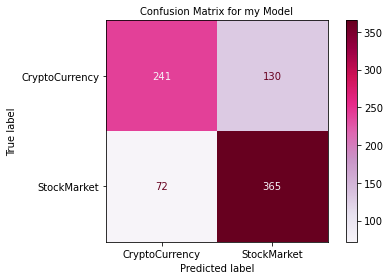

In [23]:
tn, fp, fn, tp = confusion_matrix(y_test, pipe12_gs_pred).ravel()
plot_confusion_matrix(model,X_test,y_test, 
                      display_labels=['CryptoCurrency', 'StockMarket'],
                     cmap='PuRd');
plt.title('Confusion Matrix for my Model',size=10);
plt.tight_layout();
#plt.savefig('./imgs/cm_4best_model.png');

In [24]:
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
cm = confusion_matrix(y_test, pipe12_gs_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,241,130
actual pos,72,365


In [25]:
# Get predictions mannually

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, pipe12_gs_pred).ravel()

# Calculate the specificity and precision

spec = tn / (tn + fp)
prec = tp / (tp + fp)
acc = (tp + tn)/(tp + tn + fp + fn)
sens = tp/(tp+fn)

print('Specificity:', spec)
print('Precision:', prec)
print('Sensitivty:', sens)
print('Accuracy:', acc)

Specificity: 0.6495956873315364
Precision: 0.7373737373737373
Sensitivty: 0.8352402745995423
Accuracy: 0.75


Specificity: spec = tn / (tn + fp) = 0.6496

⇢ the model predicted approximately 65% of the posts belong to the stock market subreddit

⇢ Type I Error ( or FP)  = 1- spec = 0.35

* the model incorrectly predicted 35% of the post as cryptocurrency subreddit

Sensitivity: sens = tp/(tp+fn) = 0.8352

⇢ the model correctly predicted 83.52% of the posts belong to the cryptocurrency subreddit

⇢ Type II Error ( or FN)  = 1- sens = 0.1693

* the model incorrectly predicted 16.48% of the post as StockMarket subreddit

Accuracy: acc = (tp + tn)/(tp + tn + fp + fn) = 0.75

⇢ the model predicted 75% of the posts correct
i.e., misclassification = 1 - acc = 0.25

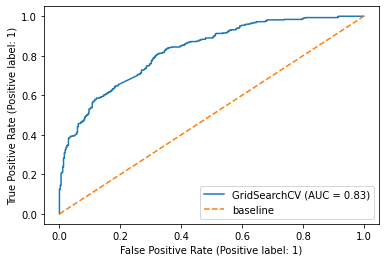

In [26]:
# ROC curve
plot_roc_curve(pipe12_gs, X_test, y_test)

# add worst case scenario line
plt.plot([0, 1], [0, 1], label="baseline", linestyle="--")

# add a legend
plt.legend();

I  want see the blue curve to be as close as possible to a square corner, thus making the area under the curve as close to 1 as possible, but it’s far but not bad.

False positive rate = type I error 

1 − specificity

= FP / (FP + TN
            




False  negative rate = type II error

   = 1 − sensitivity
   
   = FN / (TP + FN)

The ROC curve is a plot of the True Positive Rate (sensitivity) vs. the False Positive Rate (1 - specificity) for all possible decision thresholds.

* ROC is a plot of signal (True Positive Rate) against noise (False Positive Rate). ... The model performance is determined by looking at the area under the ROC curve (or AUC).


### Conclusions and Recommendations


* My Best scoring model: Logistic regression, Train / test score: 0.9089/0.7438
* Potential improvements: collect more training data, do more data cleaning and preprocessing (remove more stop words i.e., numbers, stem/lemmatize i.e. -ing verbs), more intensive gridsearching to optimize models, try more models (boosting, SVM) 

**>> Steps Forward**:

Getting real-time data using webscraping of the subreddits, make fresh predictions and make Sentiment Analysis.


References:

* [Is your model overfitting? Or maybe underfitting? An example using a neural network](https://towardsdatascience.com/is-your-model-overfitting-or-maybe-underfitting-an-example-using-a-neural-network-in-python-4faf155398d2)
* [How to Identify Overfitting Machine Learning Models in Scikit-Learn](https://machinelearningmastery.com/overfitting-machine-learning-models/)